In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys

if '..' not in sys.path:
    sys.path.append('..')

from data import OneBallFreeFallPredictionFromInitialStateWithDiameterDataset

import torch
from torch.utils.data import DataLoader

import reservoirpy as rpy
from reservoirpy.nodes import Input, Reservoir, Ridge, ReLU, ESN
from reservoirpy.observables import mse

from itertools import product

rpy.verbosity(0)
rpy.set_seed(42)

In [16]:
def calculate_test_loss(model, dataloader, dataset, visualize_first_10_trajectories=True, model_type=""):
    test_loss = (np.sum([mse(model.run(X.squeeze().numpy()), y.squeeze().numpy())*len(y) for X, y in dataloader]) / len(dataset)) ** 0.5
    print('Test loss: ', test_loss)

    if visualize_first_10_trajectories:
        fig, axs = plt.subplots(2, 5, figsize=(20,10))

        fig.suptitle('Prediction maps of first 10 test set trajectories ' + model_type, fontsize=15)
        plt.setp(axs[-1, :], xlabel='Simulation frame number')
        plt.setp(axs[:, 0], ylabel='Y-coordinate')

        for row_id in range(len(axs)):
            for col_id in range(len(axs[row_id])):
                # axs1 and axs2 are time series, so only limiting y-axis
                axs[row_id, col_id].set_ylim(0, 1)
                axs[row_id, col_id].set_ylim(0, 1)

        for X, y in dataloader:
            pred = model.run(X.squeeze().numpy())

            for count in range(10):
                axs[int(count >= 5)][count % 5].plot(np.insert(y[count].reshape(1,-1)[0], 0, X.squeeze().numpy()[count][0]), label=f'Ground truth. \nDiameter = {X.squeeze().numpy()[count][1]}')
                axs[int(count >= 5)][count % 5].plot(np.insert(pred[count].reshape(1,-1)[0], 0, X.squeeze().numpy()[count][0]), label='Predicted')
                axs[int(count >= 5)][count % 5].legend()

            break

        plt.show()
    return test_loss

In [3]:
batch_size = 32

train_data, test_data = OneBallFreeFallPredictionFromInitialStateWithDiameterDataset.train_test_split('../data/raw/single-ball-free-fall-initial-with-diameter', test_frac=0.2)

train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size)

Test size:  1072
train_test_split response: test fraction rounded to 0.19996269352732698 (1072 simulations)


In [4]:
# Parameters for cross-validation hyperparameter turning

n_units = [50, 70, 100, 150, 300]
lrs = [0.3, 0.5, 0.7]
srs = [0.95, 0.99, 0.998]
ridges = [1e-5, 1e-4, 1e-3, 1e-2]

In [5]:
# dictionary to store the results

import pickle

results = {}

try:
    with open('results_dict_1d.pkl', 'rb') as f:
        results = pickle.load(f)
except:
    results = {}

## Simple ESN Model

In [6]:
if results == {}:

    # Performing cross-validation hypterparameter turning

    results['simple_esn'] = []

    for units, lr, sr, ridge in product(n_units, lrs, srs, ridges):
        print(f'Testing units={units} \t lr={lr} \t sr={sr} \t ridge={ridge}')

        rpy.set_seed(42)

        reservoir1 = Reservoir(units=units, lr=lr, sr=sr, input_bias=False)
        readout1 = Ridge(output_dim=24, ridge=ridge) >> ReLU()

        model1 = reservoir1 >> readout1

        for X, y in train_dataloader:
            model1.fit(X.squeeze(0).numpy(), y.squeeze(0).numpy())

        test_loss = calculate_test_loss(model1, test_dataloader, test_data, visualize_first_10_trajectories=False)

        results['simple_esn'].append(
            {
                'units': units,
                'lr': lr,
                'sr': sr,
                'ridge': ridge,
                'test_loss': test_loss
            }
        )

        print()

        with open('results_dict_1d.pkl', 'wb') as f:
            pickle.dump(results, f)

Best hyperparameters: units=70 	 lr=0.7 	 sr=0.95 	 ridge=0.01
Test loss:  0.04884089163965118


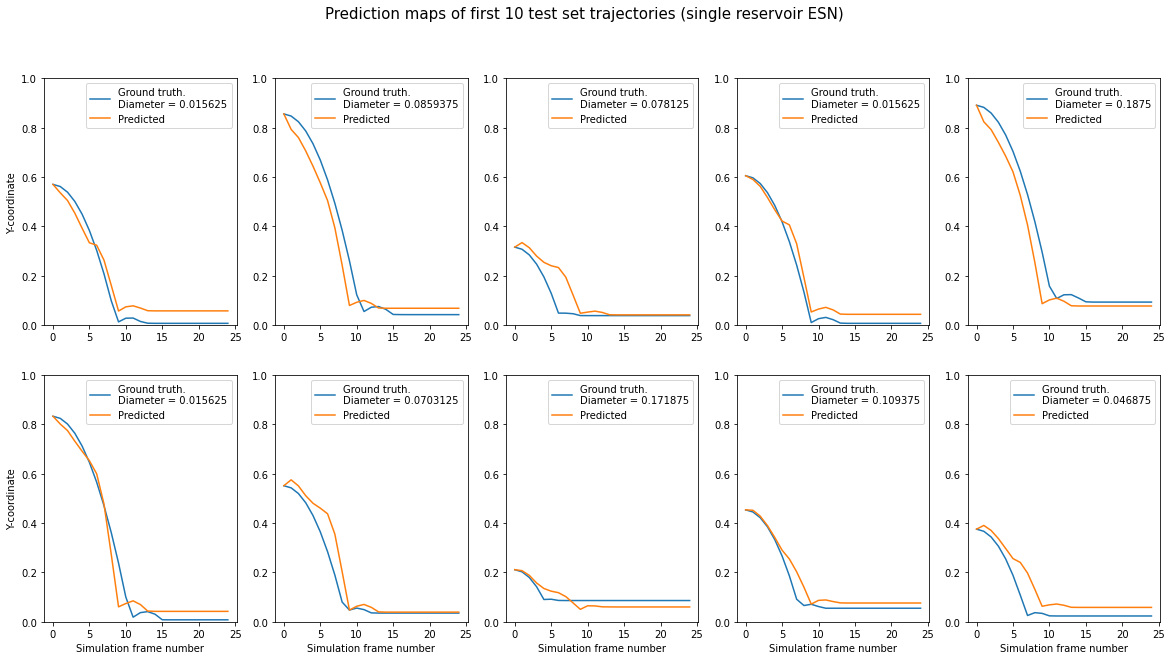

In [17]:
# Drawing the plots of first 10 trajectories in test set for the model with the best parameters

best_result = min(results['simple_esn'], key=lambda x: x['test_loss'])

rpy.set_seed(42)

reservoir1 = Reservoir(units=best_result['units'], lr=best_result['lr'], sr=best_result['sr'], input_bias=False)
readout1 = Ridge(output_dim=24, ridge=best_result['ridge']) >> ReLU()

model1 = reservoir1 >> readout1

for X, y in train_dataloader:
    model1.fit(X.squeeze(0).numpy(), y.squeeze(0).numpy())

print(f'Best hyperparameters: units={best_result["units"]} \t lr={best_result["lr"]} \t sr={best_result["sr"]} \t ridge={best_result["ridge"]}')
test_loss = calculate_test_loss(model1, test_dataloader, test_data, visualize_first_10_trajectories=True, model_type='(single reservoir ESN)')

## ESN with sequential reservoirs

Test loss:  0.061898850649011176


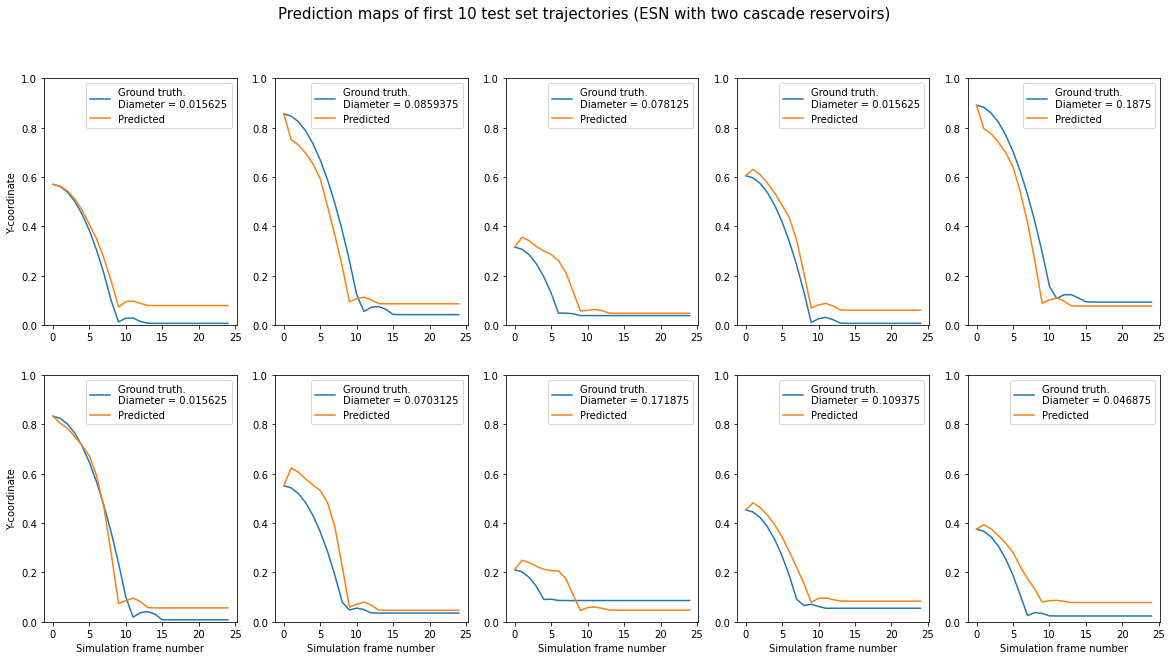

In [18]:
rpy.set_seed(42)

reservoir1 = Reservoir(units=best_result['units'], lr=best_result['lr'], sr=best_result['sr'], input_bias=False)
readout1 = Ridge(output_dim=24, ridge=best_result['ridge'])
reservoir2 = Reservoir(units=best_result['units'], lr=best_result['lr'], sr=best_result['sr'], input_bias=False)
readout2 = Ridge(output_dim=24, ridge=best_result['ridge']) >> ReLU()

model2 = reservoir1 >> readout1 >> reservoir2 >> readout2

for X, y in train_dataloader:
    model2.fit(X.squeeze(0).numpy(), y.squeeze(0).numpy())

test_loss = calculate_test_loss(model2, test_dataloader, test_data, visualize_first_10_trajectories=True, model_type='(ESN with two cascade reservoirs)')

## Deep ESN architercture

### 2 reservoirs

Test loss:  0.05578975975045059


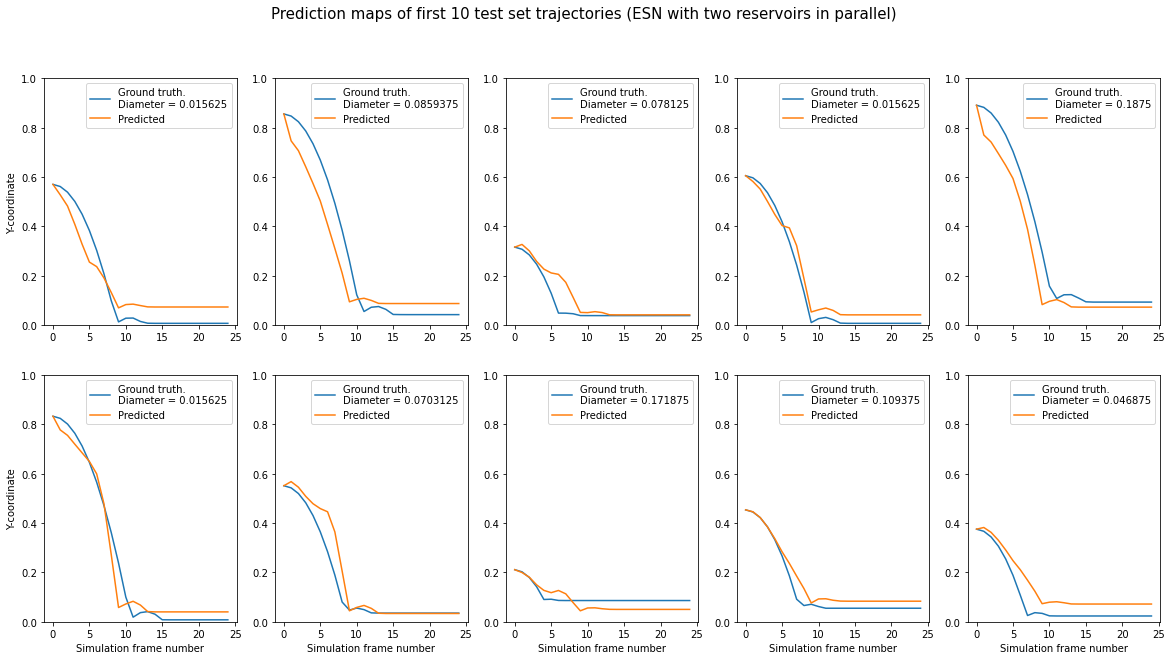

In [20]:
rpy.set_seed(42)

reservoir1 = Reservoir(units=best_result['units'], lr=best_result['lr'], sr=best_result['sr'], input_bias=False)
reservoir2 = Reservoir(units=best_result['units'], lr=best_result['lr'], sr=best_result['sr'], input_bias=False)
readout = Ridge(output_dim=24, ridge=best_result['ridge']) >> ReLU()

model4 = [reservoir1, reservoir2] >> readout & reservoir1 >> reservoir2

for X, y in train_dataloader:
    model4.fit(X.squeeze(0).numpy(), y.squeeze(0).numpy())

test_loss = calculate_test_loss(model4, test_dataloader, test_data, visualize_first_10_trajectories=True, model_type='(ESN with two reservoirs in parallel)')

### 3 reservoirs

Test loss:  0.07058243544698821


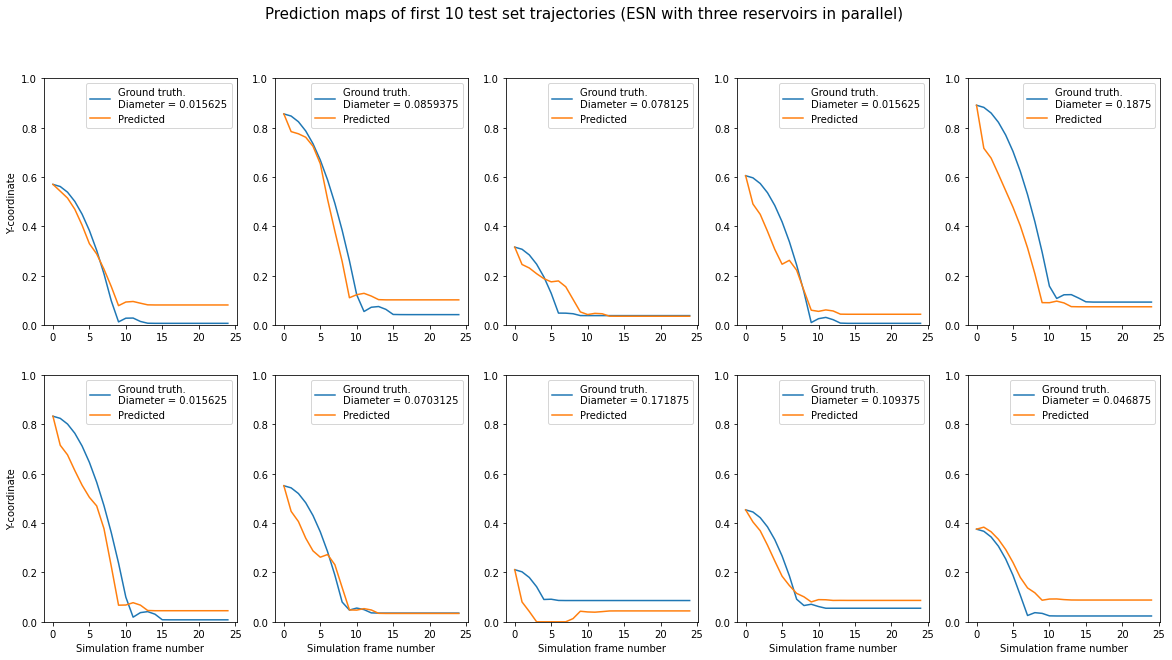

In [21]:
reservoir1 = Reservoir(units=best_result['units'], lr=best_result['lr'], sr=best_result['sr'], input_bias=False)
reservoir2 = Reservoir(units=best_result['units'], lr=best_result['lr'], sr=best_result['sr'], input_bias=False)
reservoir3 = Reservoir(units=best_result['units'], lr=best_result['lr'], sr=best_result['sr'], input_bias=False)
readout = Ridge(output_dim=24, ridge=best_result['ridge']) >> ReLU()

model5 = [reservoir1, reservoir2, reservoir3, reservoir1 >> reservoir2 >> reservoir3] >> readout

for X, y in train_dataloader:
    model5.fit(X.squeeze(0).numpy(), y.squeeze(0).numpy())

test_loss = calculate_test_loss(model5, test_dataloader, test_data, visualize_first_10_trajectories=True, model_type='(ESN with three reservoirs in parallel)')